## GHCN analysis

In [4]:
# importing dependencies

import s3fs
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import duckdb
import json

from datetime import datetime

In [3]:
# defining matplotlib theme
plt.style.use('ggplot')
# setting up the duckdb
conn = duckdb.connect()

In [9]:
# loading s3 configurations
airflow_conns = json.load(open('../connections.json'))
fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": airflow_conns['aws_s3_conn_id']['host'],
        "aws_access_key_id": airflow_conns['aws_s3_conn_id']['login'],
        "aws_secret_access_key": airflow_conns['aws_s3_conn_id']['password'],
    }
)

### Loading tables

- GHCN

In [33]:
# defining ghcn columns
columns = ['adm_name', 'year', 'element', 'value', 'distance_from_station', 'datetime']
# looking only for data from station inside the administrative area
filters = [('distance_from_station', '=', 0)]
ghcn = pq.read_table("dutrajardim-fi/tables/ghcn/osm_adm8.parquet", filesystem=fs, columns=columns, filters=filters)

In [34]:
# defining function to format chart ticks
def x_fmt_func(labels):
    return ticker.FuncFormatter(lambda x, y: datetime.strptime(labels[x][:2], "%m").strftime("%b") + labels[x][2:])

### Querying and plotting Sum of the Precipitations Chart

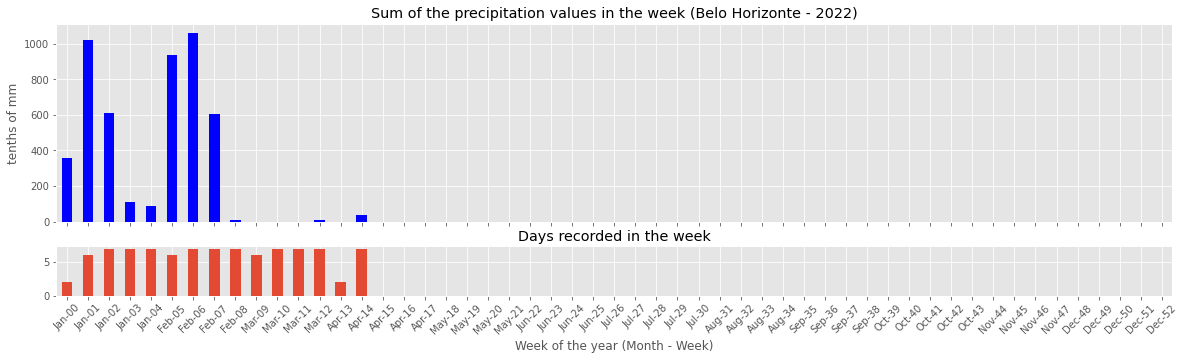

In [40]:
# defining the city
city = 'Belo Horizonte'

# defining the years for the query 
for year in range(2021, 2023):

    # quiring - generate a weekly time series (need to get the 0 counting) 
    # to join with the ghcn weekly counting
    precipitation_by_week = conn.execute(f"""
    SELECT weeks.week, COUNT(ghcn.week) AS days_recorded, SUM(ghcn.value) as agg_value
    FROM 

        (SELECT STRFTIME(generate_series, '%m-%W') as week
        FROM GENERATE_SERIES(TIMESTAMP '2021-01-01', TIMESTAMP '2021-12-31', INTERVAL 7 DAYS))
        
        weeks

    LEFT JOIN
        
        (SELECT value, STRFTIME(datetime, '%m-%W') as week
        FROM ghcn
        WHERE
            adm_name = '{city}' AND
            ghcn.year = {year} AND
            element = 'PRCP')

        ghcn 

    ON ghcn.week = weeks.week
    GROUP BY weeks.week
    ORDER BY weeks.week ASC
    """).df()

    fig, ax = plt.subplots(
        ncols=1, 
        nrows=2, 
        figsize=(20, 5), 
        sharex=True,
        gridspec_kw={'height_ratios': [4, 1]}
    )

    precipitation_by_week.plot(
        y='agg_value',
        ylabel='tenths of mm',
        ax=ax[0],
        kind='bar',
        color='blue',
        title=f"Sum of the precipitation values in the week ({city} - {year})",
        legend=False
    )

    precipitation_by_week.plot(
        y='days_recorded',
        xlabel='Week of the year (Month - Week)',
        ax=ax[1], 
        kind='bar', 
        legend=False,
        rot=45,
        title="Days recorded in the week"
    )

    ax[1].xaxis.set_major_formatter(x_fmt_func(precipitation_by_week['week']))

    # saving to docs folder
    fig.savefig(f"../docs/images/charts/BRA_MG/sum_of_precipitation_in_the_week/{year}.svg") 
    
    # if is not the last year close without print
    if year != 2022:
        plt.close(fig) 

### Querying and plotting Average Temperature in the Week Chart

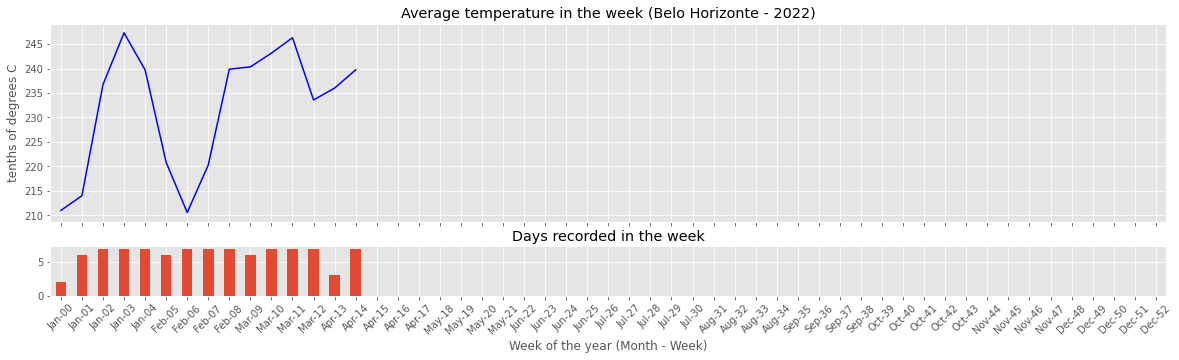

In [38]:
# defining the city
city = 'Belo Horizonte'

# defining the years for the query 
for year in range(2021, 2023):

    # querying - generate a weekly time series (need to get the 0 counting)
    # and taking the weekly average temperature with the count of records of the week
    tavg_by_week = conn.execute(f"""
    SELECT weeks.week, COUNT(ghcn.week) AS days_recorded, AVG(ghcn.value) as agg_value
    FROM 

        (SELECT STRFTIME(generate_series, '%m-%W') as week
        FROM GENERATE_SERIES(TIMESTAMP '2021-01-01', TIMESTAMP '2021-12-31', INTERVAL 7 DAYS))
        
        weeks

    LEFT JOIN
        
        (SELECT value, STRFTIME(datetime, '%m-%W') as week
        FROM ghcn
        WHERE
            adm_name = '{city}' AND
            ghcn.year = {year} AND
            element = 'TAVG')

        ghcn 

    ON ghcn.week = weeks.week
    GROUP BY weeks.week
    ORDER BY weeks.week ASC
    """).df()

    fig, ax = plt.subplots(
        ncols=1, 
        nrows=2, 
        figsize=(20, 5), 
        sharex=True,
        gridspec_kw={'height_ratios': [4, 1]}
    )

    tavg_by_week.plot(
        y='agg_value',
        ylabel='tenths of degrees C',
        ax=ax[0],
        color='blue',
        title=f"Average temperature in the week ({city} - {year})",
        legend=False
    )

    tavg_by_week.plot(
        y='days_recorded',
        xlabel='Week of the year (Month - Week)',
        ax=ax[1], 
        kind='bar', 
        legend=False,
        rot=45,
        title="Days recorded in the week"
    )

    ax[1].xaxis.set_major_formatter(x_fmt_func(tavg_by_week['week']))
    
    # saving to docs folder
    fig.savefig(f"../docs/images/charts/BRA_MG/average_temperature_in_the_week/{year}.svg") 
    
    # if is not the last year close without print
    if year != 2022:
        plt.close(fig)